In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Callable
import seaborn as sns
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    LeaveOneOut,
    StratifiedKFold,
    cross_validate,
)
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sleep_eeg.model_comparaison import *
from sleep_eeg.pre_processing.sleep_cycles import *
from sleep_eeg.pre_processing.mq import *
from sleep_eeg.plotting.sleep_cycles import *
from sleep_eeg.plotting.morning_questionnaire import *
from sleep_eeg.plotting.model_comparaison import *
from sleep_eeg.utils import *

# 0.0 Load the extracted features data

In [2]:
extracted_features_data = pd.read_csv("../data/eeg/df_corrected_110.csv", index_col=0)
extracted_features_data

,EEG E2_dwt_bounded_variation_band_0,EEG M2_dwt_bounded_variation_band_0,EEG E1_dwt_bounded_variation_band_0,EEG M1_dwt_bounded_variation_band_0,EEG Fp1_dwt_bounded_variation_band_0,EEG Fp2_dwt_bounded_variation_band_0,EEG F3_dwt_bounded_variation_band_0,EEG F4_dwt_bounded_variation_band_0,EEG C3_dwt_bounded_variation_band_0,EEG C4_dwt_bounded_variation_band_0,...,time_zero_crossing_derivative_ch_EEG T4,time_zero_crossing_derivative_ch_EEG T5,time_zero_crossing_derivative_ch_EEG T6,time_zero_crossing_derivative_ch_EEG Fz,time_zero_crossing_derivative_ch_EEG Pz,time_zero_crossing_derivative_ch_EEG Cz,time_zero_crossing_derivative_ch_EEG Oz,time_zero_crossing_derivative_ch_EEG A1,time_zero_crossing_derivative_ch_EEG A2,NAME
0,1249.326753,653.669743,1856.857403,637.846993,1682.339074,1828.124179,1154.282779,815.411050,1358.555096,1117.324054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1_N3
1,709.820526,540.162387,1604.881501,535.652855,668.329742,1960.874225,503.762478,562.374925,758.759771,644.883428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1_N4
2,1025.962497,724.226193,776.347678,576.039379,971.876928,1687.099203,3090.052078,1955.188019,3321.227981,2945.762128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1_N5
3,1233.881724,495.743780,925.375552,494.097374,2165.945089,1616.596035,1429.680435,946.791357,748.516230,2053.970576,...,728092.0,745090.0,746093.0,738039.0,740712.0,721355.0,747716.0,757249.0,757249.0,A10_N3
4,1576.781751,1062.892737,859.725768,1057.026649,1186.842982,578.530308,921.054185,1429.861410,625.080459,2554.340973,...,741748.0,748340.0,753308.0,739427.0,739923.0,717064.0,754123.0,749016.0,749016.0,A10_N4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,973.987110,973.984264,973.992748,973.984170,973.977522,973.975035,973.979457,973.976074,973.986811,973.984111,...,716101.0,716105.0,716101.0,716104.0,716103.0,716100.0,716103.0,716102.0,716102.0,B08_N4
0,914.526341,914.523560,914.535476,914.523397,914.520111,914.513677,914.519981,914.514246,914.526705,914.521566,...,722559.0,722564.0,722560.0,722564.0,722560.0,722562.0,722561.0,722559.0,722561.0,B08_N5
0,1352.476959,1352.465817,1352.480339,1352.465650,1352.462693,1352.452798,1352.468934,1352.454071,1352.481076,1352.464068,...,687676.0,687675.0,687676.0,687677.0,687675.0,687674.0,687679.0,687681.0,687680.0,B09_N3
0,970.288415,970.275389,970.293957,970.275798,970.279527,970.275930,970.283461,970.277870,970.293256,970.288271,...,690229.0,690232.0,690231.0,690231.0,690231.0,690230.0,690231.0,690229.0,690234.0,B09_N4


<Axes: >

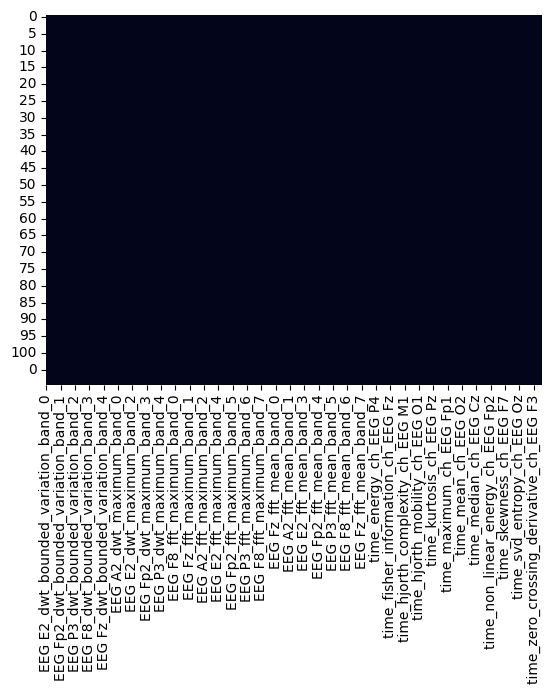

In [3]:
sns.heatmap(extracted_features_data.isna(), cbar=False)

In [4]:
extracted_features_data.index = rename_nights(extracted_features_data["NAME"])
extracted_features_data.drop(["NAME"], axis=1, inplace=True)
extracted_features_data.dropna(inplace=True)
extracted_features_data

,EEG E2_dwt_bounded_variation_band_0,EEG M2_dwt_bounded_variation_band_0,EEG E1_dwt_bounded_variation_band_0,EEG M1_dwt_bounded_variation_band_0,EEG Fp1_dwt_bounded_variation_band_0,EEG Fp2_dwt_bounded_variation_band_0,EEG F3_dwt_bounded_variation_band_0,EEG F4_dwt_bounded_variation_band_0,EEG C3_dwt_bounded_variation_band_0,EEG C4_dwt_bounded_variation_band_0,...,time_zero_crossing_derivative_ch_EEG T3,time_zero_crossing_derivative_ch_EEG T4,time_zero_crossing_derivative_ch_EEG T5,time_zero_crossing_derivative_ch_EEG T6,time_zero_crossing_derivative_ch_EEG Fz,time_zero_crossing_derivative_ch_EEG Pz,time_zero_crossing_derivative_ch_EEG Cz,time_zero_crossing_derivative_ch_EEG Oz,time_zero_crossing_derivative_ch_EEG A1,time_zero_crossing_derivative_ch_EEG A2
A01_N3,1249.326753,653.669743,1856.857403,637.846993,1682.339074,1828.124179,1154.282779,815.411050,1358.555096,1117.324054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01_N4,709.820526,540.162387,1604.881501,535.652855,668.329742,1960.874225,503.762478,562.374925,758.759771,644.883428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01_N5,1025.962497,724.226193,776.347678,576.039379,971.876928,1687.099203,3090.052078,1955.188019,3321.227981,2945.762128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10_N3,1233.881724,495.743780,925.375552,494.097374,2165.945089,1616.596035,1429.680435,946.791357,748.516230,2053.970576,...,722869.0,728092.0,745090.0,746093.0,738039.0,740712.0,721355.0,747716.0,757249.0,757249.0
A10_N4,1576.781751,1062.892737,859.725768,1057.026649,1186.842982,578.530308,921.054185,1429.861410,625.080459,2554.340973,...,739023.0,741748.0,748340.0,753308.0,739427.0,739923.0,717064.0,754123.0,749016.0,749016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B08_N4,973.987110,973.984264,973.992748,973.984170,973.977522,973.975035,973.979457,973.976074,973.986811,973.984111,...,716100.0,716101.0,716105.0,716101.0,716104.0,716103.0,716100.0,716103.0,716102.0,716102.0
B08_N5,914.526341,914.523560,914.535476,914.523397,914.520111,914.513677,914.519981,914.514246,914.526705,914.521566,...,722561.0,722559.0,722564.0,722560.0,722564.0,722560.0,722562.0,722561.0,722559.0,722561.0
B09_N3,1352.476959,1352.465817,1352.480339,1352.465650,1352.462693,1352.452798,1352.468934,1352.454071,1352.481076,1352.464068,...,687677.0,687676.0,687675.0,687676.0,687677.0,687675.0,687674.0,687679.0,687681.0,687680.0
B09_N4,970.288415,970.275389,970.293957,970.275798,970.279527,970.275930,970.283461,970.277870,970.293256,970.288271,...,690229.0,690229.0,690232.0,690231.0,690231.0,690231.0,690230.0,690231.0,690229.0,690234.0


# 0.1 Load the lantencies, continuity, age, bmi, etc... data

In [5]:
old_assembled_data, old_predictor_groups = assemble_data(
    drop_mq_grp_par_nig_dru=False, mq_class_percentiles=[0.25, 0.5, 0.75]
)

In [6]:
old_assembled_data

,bias,stage_0_to_0,stage_1_to_0,stage_0_to_1,stage_2_to_1,stage_3_to_2,stage_2_to_3,stage_5_to_2,stage_2_to_5,stage_0_to_5,...,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated,Age (y),"Sex (1=m, 2=f)",bmi (kg/m^2)
A01_N3,1.0,0,6,3.0,5,28,28,5.0,3.0,3.0,...,1,1,0,1,1,3,2,25.0,2.0,20.381570
A01_N4,1.0,0,11,4.0,7,25,25,7.0,4.0,7.0,...,0,3,0,3,0,3,3,25.0,2.0,20.381570
A01_N5,1.0,0,10,3.0,11,43,41,3.0,2.0,2.0,...,1,2,2,3,1,3,1,25.0,2.0,20.381570
A02_N3,1.0,0,11,3.0,14,27,24,8.0,5.0,3.0,...,0,3,1,1,2,3,0,30.0,1.0,23.299800
A02_N4,1.0,0,7,0.0,13,10,9,2.0,1.0,7.0,...,1,1,2,0,3,0,0,30.0,1.0,23.299800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B23_N4,1.0,0,7,0.0,9,29,29,8.0,4.0,5.0,...,2,1,2,1,3,1,0,21.0,1.0,25.057360
B23_N5,1.0,0,7,0.0,14,21,21,10.0,5.0,4.0,...,2,1,1,1,2,1,1,21.0,1.0,25.057360
B24_N3,1.0,0,15,3.0,15,39,39,8.0,4.0,7.0,...,0,2,3,0,3,1,0,27.0,1.0,23.671254
B24_N4,1.0,0,22,5.0,17,32,31,7.0,1.0,15.0,...,1,2,2,0,2,1,0,27.0,1.0,23.671254


# 0.3 Merge the two datas together

### Night ids that are inside the `old_assembled_data` but aren't in the `extracted_features_data`

In [7]:
old_assembled_data.index.difference(extracted_features_data.index), len(
    old_assembled_data.index.difference(extracted_features_data.index)
)

(Index(['A08_N3', 'A08_N5', 'A12_N3', 'A12_N4', 'A13_N3', 'A16_N4', 'A31_N3',
        'A31_N4', 'A31_N5', 'B04_N4', 'B06_N4', 'B17_N5', 'B18_N3', 'B21_N4',
        'B21_N5', 'B23_N3', 'B23_N4', 'B23_N5', 'B24_N3', 'B24_N4'],
       dtype='object'),
 20)

### Night ids that are inside the `extracted_features_data` but aren't in the `old_assembled_data`

In [8]:
extracted_features_data.index.difference(old_assembled_data.index), len(
    extracted_features_data.index.difference(old_assembled_data.index)
)

(Index(['A08_N3_1', 'B01_N4', 'B02_N4'], dtype='object'), 3)

In [9]:
extracted_features_data.drop(["sex"], axis=1, inplace=True)

In [10]:
from feature_engine.selection import DropCorrelatedFeatures

tr = DropCorrelatedFeatures(variables=None, method="kendall", threshold=0.9)
extracted_features_data = tr.fit_transform(extracted_features_data)
extracted_features_data

,EEG E2_dwt_bounded_variation_band_0,EEG M2_dwt_bounded_variation_band_0,EEG E1_dwt_bounded_variation_band_0,EEG Fp1_dwt_bounded_variation_band_0,EEG Fp2_dwt_bounded_variation_band_0,EEG F3_dwt_bounded_variation_band_0,EEG F4_dwt_bounded_variation_band_0,EEG C3_dwt_bounded_variation_band_0,EEG C4_dwt_bounded_variation_band_0,EEG P3_dwt_bounded_variation_band_0,...,time_zero_crossing_derivative_ch_EEG O1,time_zero_crossing_derivative_ch_EEG F7,time_zero_crossing_derivative_ch_EEG F8,time_zero_crossing_derivative_ch_EEG T3,time_zero_crossing_derivative_ch_EEG T4,time_zero_crossing_derivative_ch_EEG T5,time_zero_crossing_derivative_ch_EEG Fz,time_zero_crossing_derivative_ch_EEG Pz,time_zero_crossing_derivative_ch_EEG Cz,time_zero_crossing_derivative_ch_EEG A1
A01_N3,1249.326753,653.669743,1856.857403,1682.339074,1828.124179,1154.282779,815.411050,1358.555096,1117.324054,869.611675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01_N4,709.820526,540.162387,1604.881501,668.329742,1960.874225,503.762478,562.374925,758.759771,644.883428,730.968311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01_N5,1025.962497,724.226193,776.347678,971.876928,1687.099203,3090.052078,1955.188019,3321.227981,2945.762128,1289.656099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10_N3,1233.881724,495.743780,925.375552,2165.945089,1616.596035,1429.680435,946.791357,748.516230,2053.970576,755.986098,...,760469.0,719782.0,714562.0,722869.0,728092.0,745090.0,738039.0,740712.0,721355.0,757249.0
A10_N4,1576.781751,1062.892737,859.725768,1186.842982,578.530308,921.054185,1429.861410,625.080459,2554.340973,1350.460714,...,766932.0,731565.0,737117.0,739023.0,741748.0,748340.0,739427.0,739923.0,717064.0,749016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B08_N4,973.987110,973.984264,973.992748,973.977522,973.975035,973.979457,973.976074,973.986811,973.984111,973.992430,...,716106.0,716099.0,716106.0,716100.0,716101.0,716105.0,716104.0,716103.0,716100.0,716102.0
B08_N5,914.526341,914.523560,914.535476,914.520111,914.513677,914.519981,914.514246,914.526705,914.521566,914.532187,...,722560.0,722560.0,722560.0,722561.0,722559.0,722564.0,722564.0,722560.0,722562.0,722559.0
B09_N3,1352.476959,1352.465817,1352.480339,1352.462693,1352.452798,1352.468934,1352.454071,1352.481076,1352.464068,1352.486736,...,687679.0,687677.0,687677.0,687677.0,687676.0,687675.0,687677.0,687675.0,687674.0,687681.0
B09_N4,970.288415,970.275389,970.293957,970.279527,970.275930,970.283461,970.277870,970.293256,970.288271,970.297064,...,690236.0,690233.0,690228.0,690229.0,690229.0,690232.0,690231.0,690231.0,690230.0,690229.0


In [11]:
new_data = pd.merge(
    extracted_features_data, old_assembled_data, left_index=True, right_index=True
)
new_data

,EEG E2_dwt_bounded_variation_band_0,EEG M2_dwt_bounded_variation_band_0,EEG E1_dwt_bounded_variation_band_0,EEG Fp1_dwt_bounded_variation_band_0,EEG Fp2_dwt_bounded_variation_band_0,EEG F3_dwt_bounded_variation_band_0,EEG F4_dwt_bounded_variation_band_0,EEG C3_dwt_bounded_variation_band_0,EEG C4_dwt_bounded_variation_band_0,EEG P3_dwt_bounded_variation_band_0,...,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated,Age (y),"Sex (1=m, 2=f)",bmi (kg/m^2)
A01_N3,1249.326753,653.669743,1856.857403,1682.339074,1828.124179,1154.282779,815.411050,1358.555096,1117.324054,869.611675,...,1,1,0,1,1,3,2,25.0,2.0,20.381570
A01_N4,709.820526,540.162387,1604.881501,668.329742,1960.874225,503.762478,562.374925,758.759771,644.883428,730.968311,...,0,3,0,3,0,3,3,25.0,2.0,20.381570
A01_N5,1025.962497,724.226193,776.347678,971.876928,1687.099203,3090.052078,1955.188019,3321.227981,2945.762128,1289.656099,...,1,2,2,3,1,3,1,25.0,2.0,20.381570
A10_N3,1233.881724,495.743780,925.375552,2165.945089,1616.596035,1429.680435,946.791357,748.516230,2053.970576,755.986098,...,3,2,0,0,1,3,3,34.0,2.0,18.218322
A10_N4,1576.781751,1062.892737,859.725768,1186.842982,578.530308,921.054185,1429.861410,625.080459,2554.340973,1350.460714,...,0,3,0,3,0,3,3,34.0,2.0,18.218322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B08_N4,973.987110,973.984264,973.992748,973.977522,973.975035,973.979457,973.976074,973.986811,973.984111,973.992430,...,0,2,1,3,0,2,3,45.0,2.0,23.507805
B08_N5,914.526341,914.523560,914.535476,914.520111,914.513677,914.519981,914.514246,914.526705,914.521566,914.532187,...,0,3,1,1,1,2,1,45.0,2.0,23.507805
B09_N3,1352.476959,1352.465817,1352.480339,1352.462693,1352.452798,1352.468934,1352.454071,1352.481076,1352.464068,1352.486736,...,1,2,3,1,3,1,0,21.0,2.0,19.257029
B09_N4,970.288415,970.275389,970.293957,970.279527,970.275930,970.283461,970.277870,970.293256,970.288271,970.297064,...,0,3,2,1,2,1,1,21.0,2.0,19.257029


In [12]:
new_data = new_data[new_data["total_sleep_time"] >= 700]
new_data.drop(
    old_predictor_groups["psd"]
    + old_predictor_groups["resampled_times_series"]
    + old_predictor_groups["fourrier"]
    + old_predictor_groups["continuity"]
    + old_predictor_groups["changements"]
    + old_predictor_groups["durations_latencies"],
    axis=1,
    inplace=True,
)

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_7871/765393448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(


# 0.4 Extract MQ info from the new data

In [13]:
mq = new_data[old_predictor_groups["mq"]]
new_data.drop(labels=old_predictor_groups["mq"], axis=1, inplace=True)
mq

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_7871/476590029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(labels=old_predictor_groups["mq"], axis=1, inplace=True)


,Group,Participant,Night,Drug,mq_1_Sleeplatency,mq_2_times_awake,mq_3_time_lay_awake,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated
A01_N4,A,1.0,N4,1.0,45.0,2.0,15.0,0,3,0,3,0,3,3
A01_N5,A,1.0,N5,2.0,30.0,1.0,5.0,1,2,2,3,1,3,1
A10_N3,A,10.0,N3,2.0,20.0,0.0,0.0,3,2,0,0,1,3,3
A10_N4,A,10.0,N4,0.0,30.0,0.0,0.0,0,3,0,3,0,3,3
A10_N5,A,10.0,N5,1.0,60.0,1.0,10.0,0,1,0,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B08_N4,B,8.0,N4,2.0,15.0,2.0,30.0,0,2,1,3,0,2,3
B08_N5,B,8.0,N5,0.0,15.0,2.0,120.0,0,3,1,1,1,2,1
B09_N3,B,9.0,N3,2.0,15.0,5.0,20.0,1,2,3,1,3,1,0
B09_N4,B,9.0,N4,0.0,15.0,3.0,20.0,0,3,2,1,2,1,1


In [14]:
mq_class_weights = compute_class_weights(mq).to_dict()
mq_class_weights

/Users/wesleymonteith/code/ml-project-2-malm/sleep_eeg/pre_processing/mq.py:74: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  - mq_classified[classified_mq_cols].astype(int).apply(pd.value_counts)


{'mq_4_calm_sleep': {0: 0.7450980392156863,
  1: 0.7254901960784313,
  2: 0.8235294117647058,
  3: 0.7058823529411764},
 'mq_5_superficial_sleep': {0: 0.7254901960784313,
  1: 0.7745098039215687,
  2: 0.7549019607843137,
  3: 0.7450980392156863},
 'mq_6_recovery': {0: 0.7352941176470589,
  1: 0.7745098039215687,
  2: 0.696078431372549,
  3: 0.7941176470588236},
 'mq_7_bad_mood': {0: 0.7450980392156863,
  1: 0.6568627450980392,
  2: 0.8431372549019608,
  3: 0.7549019607843137},
 'mq_8_energy': {0: 0.7745098039215687,
  1: 0.7450980392156863,
  2: 0.7352941176470589,
  3: 0.7450980392156863},
 'mq_9_tense': {0: 0.7352941176470589,
  1: 0.7843137254901961,
  2: 0.7450980392156863,
  3: 0.7352941176470589},
 'mq_10_unconcentrated': {0: 0.7647058823529411,
  1: 0.6862745098039216,
  2: 0.803921568627451,
  3: 0.7450980392156863}}

# 0.5 Find which columns need to be standardized, one hot encoded, min max scaled, ...

In [15]:
new_data_summary = new_data.describe()
new_data_summary

,EEG E2_dwt_bounded_variation_band_0,EEG M2_dwt_bounded_variation_band_0,EEG E1_dwt_bounded_variation_band_0,EEG Fp1_dwt_bounded_variation_band_0,EEG Fp2_dwt_bounded_variation_band_0,EEG F3_dwt_bounded_variation_band_0,EEG F4_dwt_bounded_variation_band_0,EEG C3_dwt_bounded_variation_band_0,EEG C4_dwt_bounded_variation_band_0,EEG P3_dwt_bounded_variation_band_0,...,time_zero_crossing_derivative_ch_EEG T4,time_zero_crossing_derivative_ch_EEG T5,time_zero_crossing_derivative_ch_EEG Fz,time_zero_crossing_derivative_ch_EEG Pz,time_zero_crossing_derivative_ch_EEG Cz,time_zero_crossing_derivative_ch_EEG A1,bias,Age (y),"Sex (1=m, 2=f)",bmi (kg/m^2)
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000
mean,1907.466840,1535.452616,2047.332883,2271.942287,2365.929598,2614.548432,2669.853683,1762.919434,1948.201030,1701.398046,...,600631.725490,613677.656863,599282.166667,605830.029412,598132.098039,607550.323529,1.0,27.166667,1.725490,22.848391
std,1273.891097,1277.060278,1314.193597,1786.652322,1650.930133,1885.329749,2050.150612,1336.423657,1479.952141,1456.989316,...,252077.702126,257866.296926,251224.225718,254254.383865,250503.372358,255259.439362,0.0,6.741453,0.448471,3.073581
min,428.876592,353.370264,460.062398,521.895435,502.744600,502.128988,317.144717,315.609650,336.650015,505.878492,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,20.000000,1.000000,17.715420
25%,1017.681146,571.727530,1051.333098,976.807688,1067.903210,1077.619119,996.108303,813.740651,906.097361,847.033119,...,670191.750000,685046.500000,672356.750000,681846.750000,673893.750000,679827.000000,1.0,23.000000,1.000000,20.307412
50%,1373.269911,997.149745,1647.563024,1716.474458,1962.180343,2052.945450,2246.421111,1285.724805,1436.990469,1289.452854,...,694992.000000,711306.500000,696389.000000,698850.500000,694341.500000,701134.000000,1.0,25.000000,2.000000,22.746914
75%,2554.556241,2229.882895,2590.520371,2765.557794,3206.413340,3924.648964,3790.815601,2306.614676,2589.332834,1955.279333,...,715724.500000,737804.000000,713683.000000,720968.500000,712309.250000,722918.750000,1.0,28.000000,2.000000,24.969052
max,5895.101538,5782.571000,7121.832072,9286.581106,8317.245463,8870.678633,10774.498758,6551.208977,7559.788245,9472.094101,...,780313.000000,799969.000000,759924.000000,796034.000000,751004.000000,790449.000000,1.0,45.000000,2.000000,29.425079


In [16]:
# ohe_cols = ["woken_from_stage", "woken_by_research_team", "Sex (1=m, 2=f)"]
ohe_cols = ["Sex (1=m, 2=f)"]
len(ohe_cols)

1

In [17]:
standardize_cols = new_data.columns.difference(ohe_cols).to_list()
len(standardize_cols)

924

In [18]:
len(standardize_cols) + len(ohe_cols), new_data.shape[1]

(925, 925)

In [19]:
new_data["Sex (1=m, 2=f)"]

A01_N4    2.0
A01_N5    2.0
A10_N3    2.0
A10_N4    2.0
A10_N5    2.0
         ... 
B08_N4    2.0
B08_N5    2.0
B09_N3    2.0
B09_N4    2.0
B09_N5    2.0
Name: Sex (1=m, 2=f), Length: 102, dtype: float64

# 0.6 Start the preprocessing pipeline

In [20]:
new_data.shape

(102, 925)

In [23]:
from sklearn.decomposition import PCA

ohencoder_and_scaler = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop="if_binary"), ohe_cols),
    (StandardScaler(), standardize_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)
ohencoder_and_scaler.set_output(transform="pandas")
constant_remover = VarianceThreshold(threshold=0.0)
constant_remover.set_output(transform="pandas")


pca = PCA()

preprocess_pipe = Pipeline(
    [
        ("ohencoder_and_scaler", ohencoder_and_scaler),
        ("constant_remover", constant_remover),
        # ("pca", pca)
    ]
)

# Check if pipeline works
check_new_data_cleaned = preprocess_pipe.fit_transform(new_data)
check_new_data_cleaned.shape, new_data.shape

((102, 924), (102, 925))

# 1. Fit models with the preprocessing pipeline

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor

In [35]:
models = [
    LinearRegression(),
    Ridge(random_state=0),
    Lasso(random_state=0),
    ElasticNet(random_state=0),
    DecisionTreeRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
    # GradientBoostingClassifier(random_state=0), # Too long of a runtime
    AdaBoostRegressor(random_state=0),
    SVR(),
    LinearSVR(random_state=0),
    # NuSVC(random_state=0),
]

In [36]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective

In [43]:
search_spaces_per_model = [
    {"fit_intercept": Categorical([True, False])},
    {"alpha": Real(1e-1, 1e2, "log-uniform")},
    {"alpha": Real(1e-1, 1e2, "log-uniform")},
    {"alpha": Real(1e-1, 1e2, "log-uniform"), "l1_ratio": Real(0.0, 1.0)},
    {"max_depth": Integer(1, 20)},
    {"max_depth": Integer(1, 20), "n_estimators": Integer(50, 300)},
    {"learning_rate": Real(1e-3, 1, "log-uniform"), "n_estimators": Integer(50, 300)},
    {
        "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
        "C": Real(1e-1, 1e2, "log-uniform"),
    },
    {"C": Real(1e-1, 1e2, "log-uniform")},
    # {"kernel":Categorical(['linear', 'poly', 'rbf', 'sigmoid']), "nu": Real(0.2, 1)}, # Infeasible apprently
]

In [44]:
len(models), len(search_spaces_per_model)

(9, 9)

In [48]:
mq

,Group,Participant,Night,Drug,mq_1_Sleeplatency,mq_2_times_awake,mq_3_time_lay_awake,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated
A01_N4,A,1.0,N4,1.0,45.0,2.0,15.0,0,3,0,3,0,3,3
A01_N5,A,1.0,N5,2.0,30.0,1.0,5.0,1,2,2,3,1,3,1
A10_N3,A,10.0,N3,2.0,20.0,0.0,0.0,3,2,0,0,1,3,3
A10_N4,A,10.0,N4,0.0,30.0,0.0,0.0,0,3,0,3,0,3,3
A10_N5,A,10.0,N5,1.0,60.0,1.0,10.0,0,1,0,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B08_N4,B,8.0,N4,2.0,15.0,2.0,30.0,0,2,1,3,0,2,3
B08_N5,B,8.0,N5,0.0,15.0,2.0,120.0,0,3,1,1,1,2,1
B09_N3,B,9.0,N3,2.0,15.0,5.0,20.0,1,2,3,1,3,1,0
B09_N4,B,9.0,N4,0.0,15.0,3.0,20.0,0,3,2,1,2,1,1


In [52]:
import warnings

warnings.filterwarnings("ignore")
(
    optimised_CV_scores_across_mqs,
    best_params_across_mqs_and_models,
) = optimise_models_get_CV_scores_across_mqs(
    models=models,
    search_spaces_per_model=search_spaces_per_model,
    X=new_data,
    ys=mq.drop(mq.index.difference(new_data.index)).drop(
        [
            "Group",
            "Participant",
            "Night",
            "Drug",
            # "mq_1_Sleeplatency",
            # "mq_2_times_awake",
            # "mq_3_time_lay_awake",
            "mq_4_calm_sleep",
            "mq_5_superficial_sleep",
            "mq_6_recovery",
            "mq_7_bad_mood",
            "mq_8_energy",
            "mq_9_tense",
            "mq_10_unconcentrated",
        ],
        axis=1,
    ),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring="neg_root_mean_squared_error",
    n_iter=20,
    preprocessing_pipe=preprocess_pipe,
    class_weights=None,
    n_jobs=4,
)
warnings.filterwarnings("default")
optimised_CV_scores_across_mqs

Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.237e+00, tolerance: 2.452e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.739e+00, tolerance: 2.837e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Evaluating model: ElasticNet


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.150e+01, tolerance: 2.452e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+01, tolerance: 2.919e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+02, tolerance: 2.895e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e+02, tolerance: 3.602e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fi

Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.256e+01, tolerance: 1.058e+01
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+01, tolerance: 1.058e+01
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Evaluating model: ElasticNet


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+01, tolerance: 1.058e+01
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.742e+01, tolerance: 9.641e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

,model,fold,test_score,train_score,y_name
0,LinearRegression,0,-20.73899,-0.0,mq_1_Sleeplatency
1,LinearRegression,1,-23.812603,-0.0,mq_1_Sleeplatency
2,LinearRegression,2,-23.617177,-0.0,mq_1_Sleeplatency
3,LinearRegression,3,-25.226034,-0.0,mq_1_Sleeplatency
4,LinearRegression,4,-22.153618,-0.0,mq_1_Sleeplatency
...,...,...,...,...,...
130,LinearSVR,0,-24.790285,-27.66361,mq_3_time_lay_awake
131,LinearSVR,1,-29.495811,-24.727836,mq_3_time_lay_awake
132,LinearSVR,2,-35.577168,-27.518165,mq_3_time_lay_awake
133,LinearSVR,3,-51.130131,-17.276995,mq_3_time_lay_awake


In [53]:
optimised_CV_scores_across_mqs.to_csv(
    "../data/eeg/reg_optimised_CV_scores_across_mqs.csv"
)

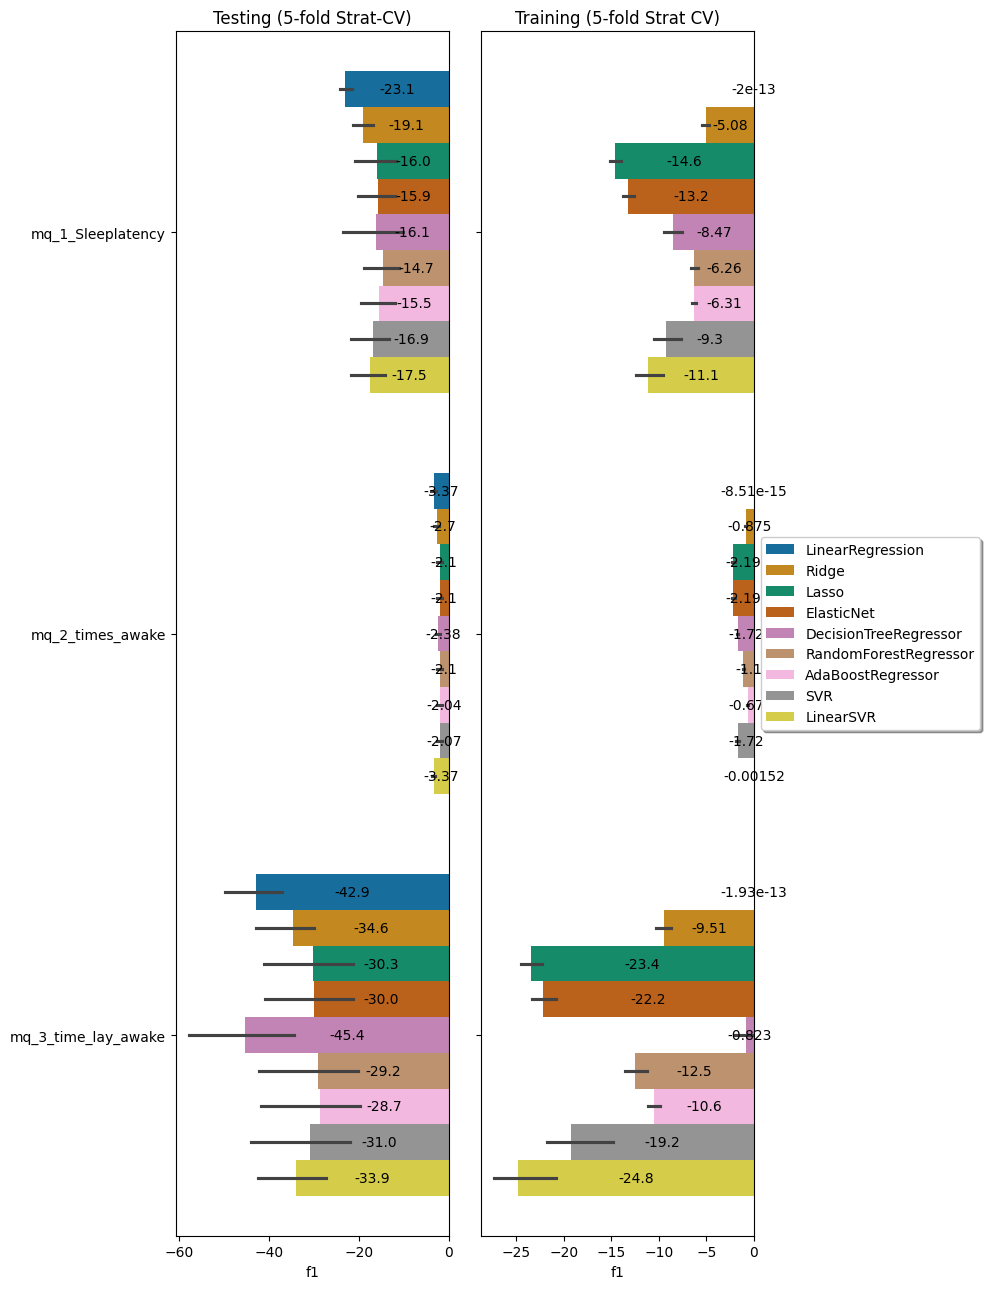

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 13))  # , sharex=True)
sns.barplot(
    data=optimised_CV_scores_across_mqs,
    y="y_name",
    x="test_score",
    hue="model",
    legend=False,
    palette="colorblind",
    # errorbar=None,
    ax=axes[0],
)
for i in axes[0].containers:
    axes[0].bar_label(i, label_type="center", fmt="{:.3}")
axes[0].set_xlabel("f1")
axes[0].set_ylabel("")
axes[0].set_title("Testing (5-fold Strat-CV)")
# axes[0].legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

sns.barplot(
    data=optimised_CV_scores_across_mqs,
    y="y_name",
    x="train_score",
    hue="model",
    # legend=False,
    palette="colorblind",
    # errorbar=None,
    ax=axes[1],
)
for i in axes[1].containers:
    axes[1].bar_label(i, label_type="center", fmt="{:.3}")
axes[1].set_xlabel("f1")
axes[1].set_title("Training (5-fold Strat CV)")
axes[1].set_ylabel("")
axes[1].set_yticklabels([])
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("../figures/tuned_models_test_train_f1.png", dpi=400, bbox_inches="tight")
plt.show()

In [56]:
import pickle

with open("reg_optimised_CV_scores_across_mqs.pkl", "wb") as f:
    pickle.dump(
        {
            "optimised_CV_scores_across_mqs": optimised_CV_scores_across_mqs,
            "best_params_across_mqs_and_models": best_params_across_mqs_and_models,
        },
        f,
    )